# Ranking SP occurences for Exploration

We aim to use the detection algorithm in order to guide a user in data exploration, so we need to decide a ranking to present them.  



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.feature_selection as feat_sel

import detect_simpsons_paradox as dsp
import fairsim as spdata
from fairsim import sp_plot
import itertools as itertx

/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


First, we need to sample data that has SP.

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,9.506626,10.834185,10.465789,5.964158,16.532344,14.635015,A2,B0,C1
1,11.325698,14.229936,10.238096,5.976300,17.875043,13.636950,A1,B0,C1
2,9.175534,16.360021,9.324127,7.396804,9.696030,8.927674,A0,B0,C0
3,9.076482,15.999306,8.949351,7.725003,9.632856,13.356340,A0,B0,C3
4,14.857056,12.037595,10.875164,7.101678,4.167995,15.208601,A1,B0,C4


We'll also plot them in the dimensions where we added SP

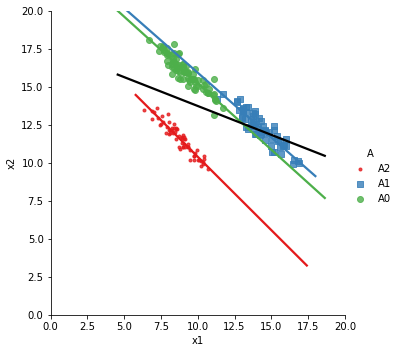

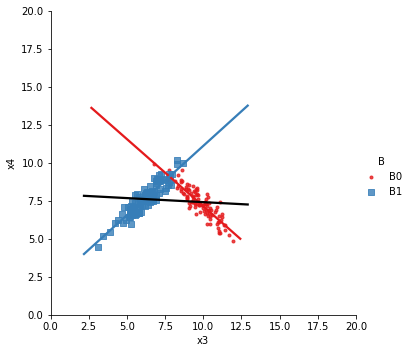

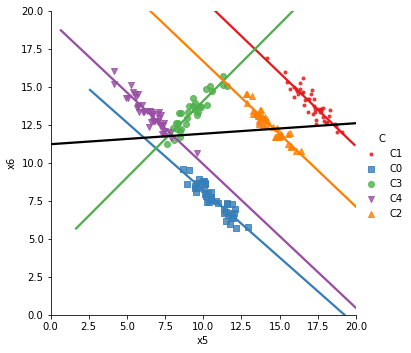

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
plt.axis(domain_range)
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


Next, we can apply our detection algorithm and mark which rows were designed in and which were not

In [4]:
many_sp_df_diff_result = dsp.mark_designed_rows(dsp.detect_simpsons_paradox(many_sp_df_diff),sp_design_list)
many_sp_df_diff_result.head() # we only need to see a little

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed
0,0.086663,x1,x5,-0.062332,A,A0,False
1,0.072005,x2,x3,-0.173685,A,A0,False
2,-0.077541,x2,x5,0.066363,A,A0,False
3,-0.105078,x3,x4,0.009856,A,A0,False
4,-0.010510,x3,x5,0.076433,A,A0,False


We see that in the first few rows therea re both designed and unintentional occurences, we can get the counts for earch here:

In [5]:
many_sp_df_diff_result['designed'].value_counts()

False    44
True      5
Name: designed, dtype: int64

We can look at the correlatiton coefficients first

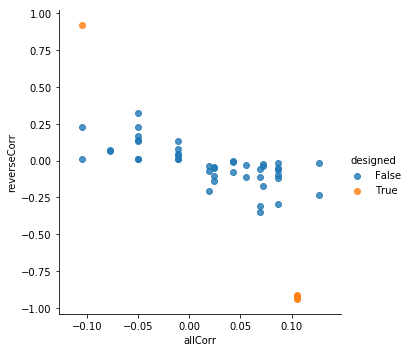

In [6]:

sns.lmplot('allCorr','reverseCorr',data=many_sp_df_diff_result, fit_reg=False,hue='designed')

This shows that the first thing we can to to filter/ improve is to rank by the correlation coefficients. WHile somem of these may be strong relationships that are just highly nonlinenar, this is a first pass filter to remove false relationships. 

In [7]:
many_sp_df_diff_result.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,44.0,0.020008,0.061245,-0.105078,-0.020366,0.024095,0.069820,0.126352
True,5.0,0.063291,0.094121,-0.105078,0.105383,0.105383,0.105383,0.105383


Next we can look at angles between lines, we have functions for these added to the detect_simpsons_paradox module so and these will all add columns.  

In [17]:
results_df_slopes = dsp.add_slope_sp(many_sp_df_diff, many_sp_df_diff_result)
all_slopes_df = dsp.compute_slope_all(many_sp_df_diff, ['x' +str(i+1) for i in range(n_views*2)])
all_slopes_df

,attr1,attr2,all_slope
0,x1,x2,-0.379823
1,x1,x3,0.042486
2,x1,x4,0.016439
3,x1,x5,0.128488
4,x1,x6,0.067065
5,x2,x3,0.065420
6,x2,x4,-0.047679
7,x2,x5,-0.136635
8,x2,x6,-0.057607
9,x3,x4,-0.053203


In [45]:
# a = list(set(results_df_slopes['attr1']))
# a.extend(set(results_df_slopes['attr2']))
# set(a)
set(np.append(results_df_slopes.attr1.values,results_df_slopes.attr2.values))

{'x1', 'x2', 'x3', 'x4', 'x5', 'x6'}

In [63]:
set([(a,b) for a,b in zip(results_df_slopes.attr1.values,results_df_slopes.attr2.values)])

{('x1', 'x3'),
 ('x1', 'x4'),
 ('x1', 'x5'),
 ('x1', 'x6'),
 ('x2', 'x3'),
 ('x2', 'x5'),
 ('x2', 'x6'),
 ('x3', 'x4'),
 ('x3', 'x5'),
 ('x3', 'x6'),
 ('x4', 'x5'),
 ('x4', 'x6'),
 ('x5', 'x6')}

In [75]:
import string

In [86]:
weights = [.4,.6]
cols_list = ['angle','allCorr']
'_'.join([str(w) + c for c,w, in zip(cols_list,weights)])
wsum = lambda r: np.average(r,weights=weights)
results_df_slopes[cols_list].agg(wsum,axis="columns")

0      7.670606
1      6.791081
2      3.776497
3      3.106005
4      5.624749
5      4.078341
6      8.981104
7      2.605328
8      1.903928
9     -8.355151
10    -3.876495
11    -1.403540
12   -18.209476
13    -3.663578
14    -3.596439
15    -2.174246
16   -11.032954
17    -0.606742
18    -0.618997
19    -0.937883
20     2.233658
21     2.765058
22     6.967151
23     4.060982
24     2.081998
25     5.074913
26    -8.478401
27    -2.057083
28    -3.357592
29    -1.496172
30    -2.719962
31    -3.271827
32    -5.231030
33     3.396780
34     1.205222
35     1.209383
36     2.515063
37     2.999083
38     2.882016
39     5.788219
40     0.471136
41     0.412198
42     0.993472
43    18.280246
44    19.243443
45    19.125659
46    18.994154
47    15.591660
48    10.739715
dtype: float64

In [82]:
results_df_slopes.groupby(['attr1','attr2','groupbyAttr'])['subgroup'].count().reset_index().head()

,attr1,attr2,groupbyAttr,subgroup
0,x1,x3,A,1
1,x1,x3,C,1
2,x1,x4,C,3
3,x1,x5,A,2
4,x1,x5,C,4


In [58]:
print('subgroup_slope' in results_df_slopes.columns and 'all_slope' in results_df_slopes.columns)
results_df_slopes.head()

True


,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.086663,x1,x5,-0.062332,A,A0,False,-0.207542,0.128488,19.046521
1,0.086663,x1,x5,-0.047134,A,A1,False,-0.167810,0.128488,16.847708
2,0.086663,x1,x5,-0.098705,C,C1,False,-0.034738,0.128488,9.311247
3,0.086663,x1,x5,-0.014063,C,C2,False,-0.005469,0.128488,7.635017
4,0.086663,x1,x5,-0.292686,C,C3,False,-0.115884,0.128488,13.931878


In [57]:
results_df_slopes = results_df_slopes.merge(all_slopes_df, left_on=['attr1','attr2'], right_on=['attr1','attr2'])
results_df_slopes['angle'] = results_df_slopes.apply(dsp.compute_angle,axis=1)
results_df_slopes.head()

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.086663,x1,x5,-0.062332,A,A0,False,-0.207542,0.128488,19.046521
1,0.086663,x1,x5,-0.047134,A,A1,False,-0.167810,0.128488,16.847708
2,0.086663,x1,x5,-0.098705,C,C1,False,-0.034738,0.128488,9.311247
3,0.086663,x1,x5,-0.014063,C,C2,False,-0.005469,0.128488,7.635017
4,0.086663,x1,x5,-0.292686,C,C3,False,-0.115884,0.128488,13.931878


In [9]:
results_df_slopes.sort_values('angle',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
44,0.105383,x5,x6,-0.910761,C,C1,True,-0.965813,0.068995,47.950532
45,0.105383,x5,x6,-0.939119,C,C2,True,-0.955929,0.068995,47.656073
46,0.105383,x5,x6,-0.929668,C,C4,True,-0.945007,0.068995,47.327311
43,0.105383,x5,x6,-0.916821,C,C0,True,-0.887707,0.068995,45.542541
47,0.126352,x4,x5,-0.231466,C,C1,False,-0.230183,0.483999,38.789622
48,0.126352,x4,x5,-0.018606,C,C2,False,-0.014537,0.483999,26.659759
6,0.072005,x2,x3,-0.173685,A,A0,False,-0.336572,0.065420,22.344753
0,0.086663,x1,x5,-0.062332,A,A0,False,-0.207542,0.128488,19.046521
22,0.069092,x1,x6,-0.109460,A,A1,False,-0.239662,0.067065,17.314240
1,0.086663,x1,x5,-0.047134,A,A1,False,-0.167810,0.128488,16.847708


In [10]:
results_df_slopes.sort_values('allCorr',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
48,0.126352,x4,x5,-0.018606,C,C2,False,-0.014537,0.483999,26.659759
47,0.126352,x4,x5,-0.231466,C,C1,False,-0.230183,0.483999,38.789622
46,0.105383,x5,x6,-0.929668,C,C4,True,-0.945007,0.068995,47.327311
45,0.105383,x5,x6,-0.939119,C,C2,True,-0.955929,0.068995,47.656073
44,0.105383,x5,x6,-0.910761,C,C1,True,-0.965813,0.068995,47.950532
43,0.105383,x5,x6,-0.916821,C,C0,True,-0.887707,0.068995,45.542541
1,0.086663,x1,x5,-0.047134,A,A1,False,-0.167810,0.128488,16.847708
0,0.086663,x1,x5,-0.062332,A,A0,False,-0.207542,0.128488,19.046521
2,0.086663,x1,x5,-0.098705,C,C1,False,-0.034738,0.128488,9.311247
3,0.086663,x1,x5,-0.014063,C,C2,False,-0.005469,0.128488,7.635017


In [60]:
results_df_slopes.sort_values('angle', ascending=False).rank(numeric_only=True).head(10)

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
44,45.5,4.0,47.0,1.0,39.5,49.0
45,45.5,1.0,47.0,2.0,39.5,48.0
46,45.5,2.0,47.0,3.0,39.5,47.0
43,45.5,3.0,47.0,4.0,39.5,46.0
47,48.5,8.0,22.5,7.0,48.5,45.0
48,48.5,28.0,22.5,28.0,48.5,44.0
6,36.0,10.0,22.5,5.0,32.0,43.0
0,40.5,19.0,22.5,8.0,44.5,42.0
22,32.5,14.0,22.5,6.0,35.5,41.0
1,40.5,22.0,22.5,10.0,44.5,40.0


Above is a table of the rank of each sample, in each variable.  We can see that when sorted 

We can look at the spearman correlation of the various features.  THis is equic

In [12]:
results_df_slopes.corr(method='spearman')

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
allCorr,1.000000,-0.797138,0.282536,-0.797138,0.945637,0.896870
reverseCorr,-0.797138,1.000000,-0.314643,0.945102,-0.789963,-0.907245
designed,0.282536,-0.314643,1.000000,-0.314643,0.210705,0.314643
subgroup_slope,-0.797138,0.945102,-0.314643,1.000000,-0.798266,-0.951633
all_slope,0.945637,-0.789963,0.210705,-0.798266,1.000000,0.904967
angle,0.896870,-0.907245,0.314643,-0.951633,0.904967,1.000000


In [13]:
results_df_slopes.groupby('designed')['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,44.0,2.984036,12.682617,-27.566620,-5.155817,3.819564,9.495640,38.789622
True,5.0,28.622077,41.371235,-45.366072,45.542541,47.327311,47.656073,47.950532


In [14]:
results_df_slopes.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,44.0,0.020008,0.061245,-0.105078,-0.020366,0.024095,0.069820,0.126352
True,5.0,0.063291,0.094121,-0.105078,0.105383,0.105383,0.105383,0.105383


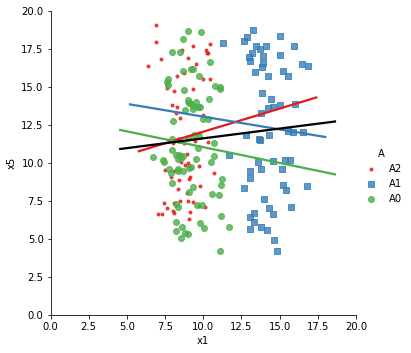

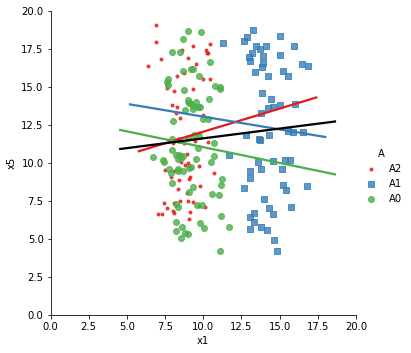

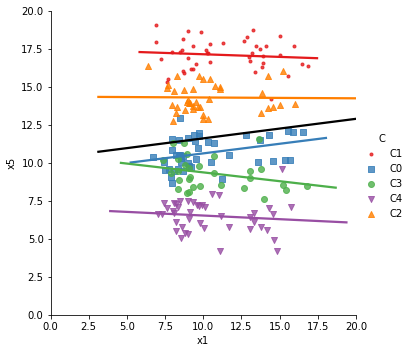

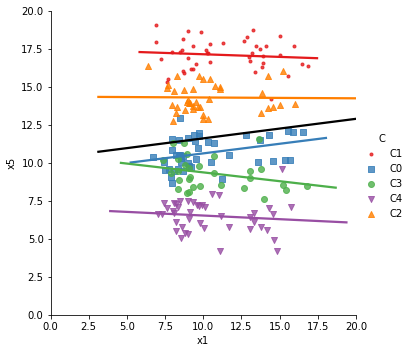

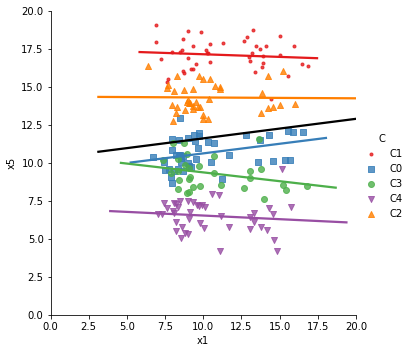

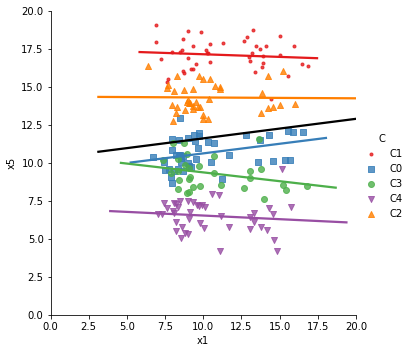

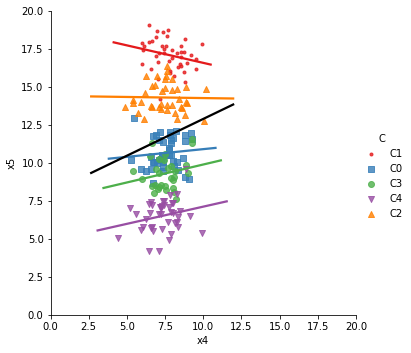

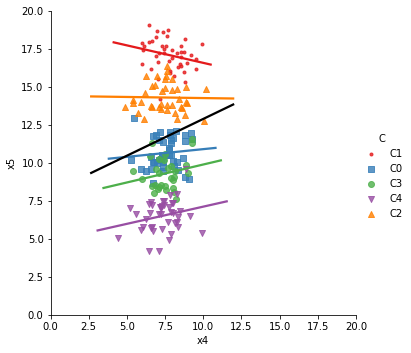

In [15]:

for row in results_df_slopes[['allCorr','attr1','attr2','groupbyAttr','designed']].values:
    if not row[4] and row[0] >.08:
        sp_plot(many_sp_df_diff,row[1],row[2],row[3])

In [16]:
many_sp_df_diff.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'A', 'B', 'C'], dtype='object')

Another way we might want to examine the subgroups is to see if the errors to the whole data set model orelate with class.  Ths is if the errors are hihgly deparable, thn 